Luis Quiñones, Tobias Pfeiffer

In [1]:
import cv2
import glob
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from numpy.random import seed
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from PIL import Image
from tensorflow.python import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Input
from tensorflow.keras.layers import Dense, Activation, Dropout, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.preprocessing import image
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Sequential, load_model, model_from_yaml
from keras.layers import concatenate
import requests
import os


### Helper Functions: 

In [2]:
def grad_cam(model, img,
             layer_name="block5_conv3", label_name=None,
             category_id=None):
    """Get a heatmap by Grad-CAM.

    Args:
        model: A model object, build from tf.keras 2.X.
        img: An image ndarray.
        layer_name: A string, layer name in model.
        label_name: A list or None,
            show the label name by assign this argument,
            it should be a list of all label names.
        category_id: An integer, index of the class.
            Default is the category with the highest score in the prediction.

    Return:
        A heatmap ndarray(without color).
    """
    img_tensor = np.expand_dims(img, axis=0)

    conv_layer = model.get_layer(layer_name)
    heatmap_model = Model([model.inputs], [conv_layer.output, model.output])

    with tf.GradientTape() as gtape:
        conv_output, predictions = heatmap_model(img_tensor)
        if category_id is None:
            category_id = np.argmax(predictions[0])
        if label_name is not None:
            print(label_name[category_id])
        output = predictions[:, category_id]
        grads = gtape.gradient(output, conv_output)
        pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_output), axis=-1)
    heatmap = np.maximum(heatmap, 0)
    max_heat = np.max(heatmap)
    if max_heat == 0:
        max_heat = 1e-10
    heatmap /= max_heat

    return np.squeeze(heatmap)



In [3]:
def preprocess_image(img_path, target_size=(512, 512)):
    """Preprocess the image by reshape and normalization.

    Args:
        img_path: A string.
        target_size: A tuple, reshape to this size.
    Return:
        An image array.
    """
    img = image.load_img(img_path, target_size=target_size)
    img = image.img_to_array(img)
    img /= 255

    return img


def show_imgwithheat(img_path, heatmap, alpha=0.5, return_array=False):
    """Show the image with heatmap.

    Args:
        img_path: string.
        heatmap: image array, get it by calling grad_cam().
        alpha: float, transparency of heatmap.
        return_array: bool, return a superimposed image array or not.
    Return:
        None or image array.
    """
    img = cv2.imread(img_path)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = (heatmap*255).astype("uint8")
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = heatmap * alpha + img
    superimposed_img = np.clip(superimposed_img, 0, 255).astype("uint8")
    superimposed_img = cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB)

    imgwithheat = Image.fromarray(superimposed_img)

    if return_array:
        return superimposed_img
    else:
        try:
            display(imgwithheat)
        except NameError:
            imgwithheat.show()

Load the data:

In [4]:
#textfile_path = "C:\\Users\\HP\\Desktop\\Barcelona\\Term3\\DeepLearningApplication\\term_paper\\HousesDataset\\HousesInfo.txt"
textfile_path = "HousesDataset/HousesInfo.txt"

col = ["bedrooms", "bathrooms", "area", "zipcode", "price"]

text_data = pd.read_csv(textfile_path, sep = ' ', names = col)

text_data.head(10)

bedrooms  bathrooms  area  zipcode    price
0         4        4.0  4053    85255   869500
1         4        3.0  3343    36372   865200
2         3        4.0  3923    85266   889000
3         5        5.0  4022    85262   910000
4         3        4.0  4116    85266   971226
5         4        5.0  4581    85266  1249000
6         3        4.0  2544    85262   799000
7         4        5.0  5524    85266  1698000
8         3        4.0  4229    85255  1749000
9         4        5.0  3550    85262  1500000

Since house prices have a high magnitude we use the highest price to scale.

In [5]:
p_max = text_data['price'].max()

In [6]:
y = text_data['price']
text_data = text_data.drop(columns='price', axis=1)

X = text_data

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.9, random_state=420)

The following fucntion groups the photos associated with an id into one. *image_split_lr()* produced a low resolution image while *image_split_hr()* produces a high resolution image. We hope differences in the MSE/R² can help to quantify the effect of visual features.

In [7]:
def image_split(df, new_size):
    images = []

    for i in df.index.values:
        housePaths = sorted(list(glob.glob("HousesDataset/{}_*".format(i+1))))

        inputImages = []
        outputImage = np.zeros((new_size, new_size, 3), dtype = "uint8")
                
        for housePath in housePaths : 
            image = cv2.imread(housePath)
            image = cv2.resize(image, (new_size//2, new_size//2), interpolation = cv2.INTER_CUBIC)
            inputImages.append(image)

            if len(inputImages) >= 4: 
                outputImage[0:new_size//2, 0:new_size//2] = inputImages[0]
                outputImage[0:new_size//2, new_size//2:new_size] = inputImages[1]
                outputImage[new_size//2:new_size, new_size//2:new_size] = inputImages[2]
                outputImage[new_size//2:new_size, 0:new_size//2] = inputImages[3]
            
                images.append(outputImage)

    return images


In [8]:
X_train_img_lr = image_split(y_train, 64)
X_test_img_lr = image_split(y_test, 64)

X_train_img_hr = image_split(y_train, 512)
X_test_img_hr = image_split(y_test, 512)

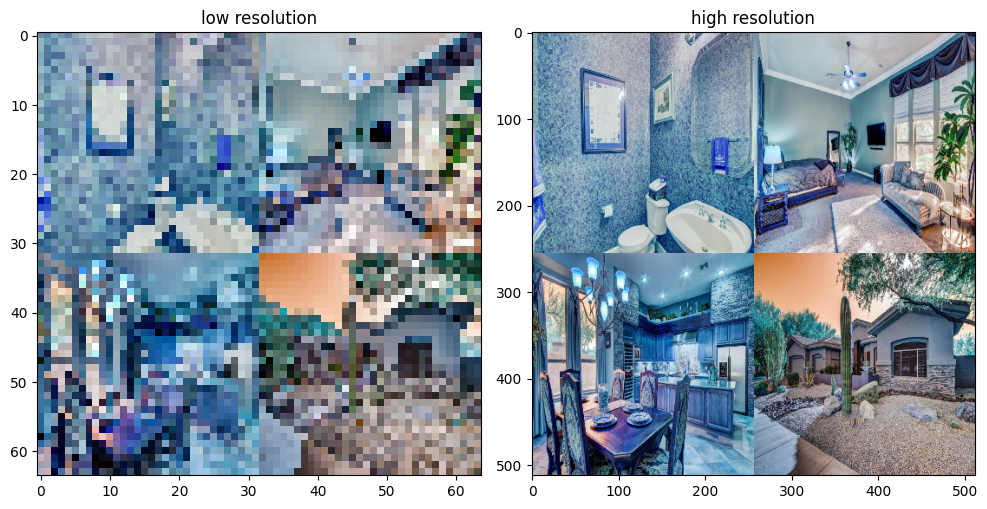

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].imshow(X_train_img_lr[1])
axs[0].set_title('low resolution')

axs[1].imshow(X_train_img_hr[1])
axs[1].set_title('high resolution')

plt.tight_layout()

plt.show()

In [10]:
# standarise images
X_train_img_lr = np.multiply(X_train_img_lr, (1/255))
X_test_img_lr = np.multiply(X_test_img_lr, (1/255))

X_train_img_hr = np.multiply(X_train_img_hr, (1/255))
X_test_img_hr = np.multiply(X_test_img_hr, (1/255))

# y is the price of the house corresponding to house i
y_train = np.stack(y_train)
y_train = y_train / p_max
y_test = np.stack(y_test)
y_test = y_test / p_max

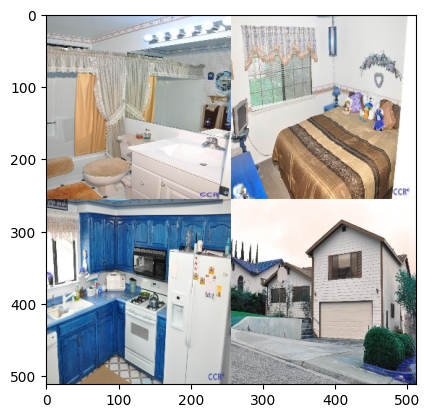

In [11]:
# visualisation pt. II
plt.imshow(X_test_img_hr[3])
plt.show()

In [12]:
# check dimensions:
print(f'{X_train_img_lr.shape} is the dimension of the training images (lr)')
print(f'{X_train_img_hr.shape} is the dimension of the training images (hr)')
print(f'{X_train.shape} is the dimension of the training data')
print(f'{y_train.shape} is the dimension of y train')

print(f'{X_test_img_lr.shape} is the dimension of the testing images (lr)')
print(f'{X_test_img_hr.shape} is the dimension of the testing images (hr)')
print(f'{X_test.shape} is the dimension of the testing data')
print(f'{y_test.shape} is the dimension of y test')

(481, 64, 64, 3) is the dimension of the training images (lr)
(481, 512, 512, 3) is the dimension of the training images (hr)
(481, 4) is the dimension of the training data
(481,) is the dimension of y train
(54, 64, 64, 3) is the dimension of the testing images (lr)
(54, 512, 512, 3) is the dimension of the testing images (hr)
(54, 4) is the dimension of the testing data
(54,) is the dimension of y test


In [13]:
print(X_train.isna().sum())
print(X_test.isna().sum())

bedrooms     0
bathrooms    0
area         0
zipcode      0
dtype: int64
bedrooms     0
bathrooms    0
area         0
zipcode      0
dtype: int64


In [14]:
def standardise_df(df, df_test):

    scaler = MinMaxScaler()

    df_standardized = scaler.fit_transform(df)
    df_standardized_test = scaler.transform(df_test)

    return df_standardized, df_standardized_test

In [15]:
X_train, X_test = standardise_df(X_train, X_test)

### Model
1. Build Baseline Model (Neural Network for tabular data)
2. Build Low Resolution Model
3. Build High Resolution Model

In [16]:
baseline = Sequential()
baseline.add(Dropout(0.2, input_shape=(4,)))
baseline.add(Dense(16, activation='relu'))
baseline.add(Dense(4, activation='relu'))
baseline.add(Dense(1, activation='linear'))
baseline.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])

In [17]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1)
history_baseline = baseline.fit(X_train, y_train, epochs = 30, batch_size = 32, 
                    #validation_data=([X_val, X_val_img], y_val), 
                    callbacks=[early_stopping], validation_split = (1/9))

Epoch 1/30
14/14 [==============================] - 2s 28ms/step - loss: 0.0315 - mean_squared_error: 0.0315 - val_loss: 0.0109 - val_mean_squared_error: 0.0109
Epoch 2/30
14/14 [==============================] - 0s 9ms/step - loss: 0.0104 - mean_squared_error: 0.0104 - val_loss: 0.0031 - val_mean_squared_error: 0.0031
Epoch 3/30
14/14 [==============================] - 0s 11ms/step - loss: 0.0077 - mean_squared_error: 0.0077 - val_loss: 0.0034 - val_mean_squared_error: 0.0034
Epoch 4/30
14/14 [==============================] - 0s 11ms/step - loss: 0.0074 - mean_squared_error: 0.0074 - val_loss: 0.0029 - val_mean_squared_error: 0.0029
Epoch 5/30
14/14 [==============================] - 0s 11ms/step - loss: 0.0067 - mean_squared_error: 0.0067 - val_loss: 0.0029 - val_mean_squared_error: 0.0029
Epoch 6/30
14/14 [==============================] - 0s 11ms/step - loss: 0.0068 - mean_squared_error: 0.0068 - val_loss: 0.0028 - val_mean_squared_error: 0.0028
Epoch 7/30
14/14 [=================

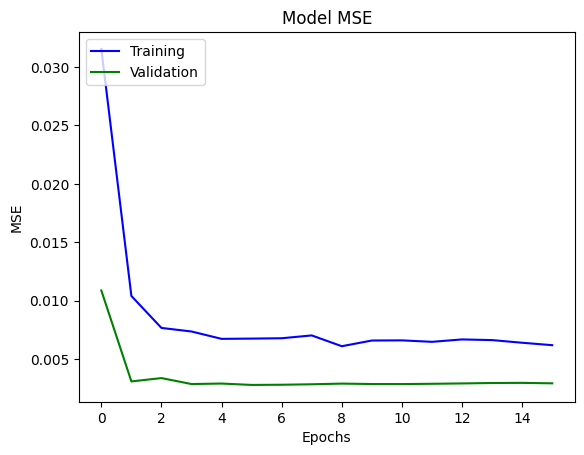

In [18]:
plt.plot(history_baseline.history['loss'], color='b')
plt.plot(history_baseline.history['val_loss'], color='g')

plt.title('Model MSE')
plt.ylabel('MSE')
plt.xlabel('Epochs')

plt.legend(['Training', 'Validation'], loc='upper left')

plt.show()

In [19]:
predictions_baseline = baseline.predict(X_test)

2/2 [==============================] - 0s 3ms/step


In [20]:
error = predictions_baseline.flatten() - y_test
squared_error = error ** 2
MSE_baseline = np.mean(squared_error)
print(MSE_baseline)

0.0029494763953590852


In [21]:
def tabular_nn():
    nn = Sequential()
    nn.add(Dropout(0.2, input_shape=(4,)))
    nn.add(Dense(16, activation='relu'))
    nn.add(Dense(4, activation='relu'))
    nn.add(Dense(1, activation='linear'))
    return nn

In [22]:
def cnn(size):
    model = Sequential()

    initializer = 'he_uniform'  # Set the initializer

    model.add(Input(shape=size, name='input_layer'))

    model.add(Conv2D(filters=16, kernel_size=(7, 7), strides=(2,2), padding='same', activation=None, use_bias=False, kernel_initializer=initializer, name='conv_layer1'))
    model.add(BatchNormalization(name='batchnorm_layer1'))
    model.add(Activation('relu', name='activation_layer1'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid', name='pool_layer1'))

    model.add(Conv2D(filters=32, kernel_size=(5, 5), padding='same', activation=None, use_bias=False, kernel_initializer=initializer, name='conv_layer2'))
    model.add(BatchNormalization(name='batchnorm_layer2'))
    model.add(Activation('relu', name='activation_layer2'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid', name='pool_layer2'))

    model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation=None, use_bias=False, kernel_initializer=initializer, name='conv_layer3'))
    model.add(BatchNormalization(name='batchnorm_layer3'))
    model.add(Activation('relu', name='activation_layer3'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid', name='pool_layer3'))

    model.add(Flatten(name='flatten_layer'))

    model.add(Dense(units=256, activation=None, kernel_initializer=initializer, name='dense_layer1'))
    model.add(BatchNormalization(name='batchnorm_layer4'))
    model.add(Activation('relu', name='activation_layer4'))

    model.add(Dense(units=128,  activation=None, kernel_initializer=initializer, name='dense_layer2'))
    model.add(BatchNormalization(name='batchnorm_layer5'))
    model.add(Activation('softmax', name='activation_layer5'))

    model.add(Dense(units=4,  activation='softmax', kernel_initializer=initializer, name='output_layer'))

    return model


In [23]:
tabular_model = tabular_nn()
cnn_model_lr = cnn((64, 64, 3))
cnn_model_hr = cnn((512, 512, 3))

def merge_models(tabular_model, cnn_model):
    merged = concatenate([tabular_model.output, cnn_model.output])
    final_dense = Dense(4, activation='relu')(merged)
    output = Dense(1, activation='linear')(final_dense)

    return Model(inputs=[tabular_model.input, cnn_model.input], outputs=output)

2. low resolution:

In [24]:
model_lr = merge_models(tabular_model, cnn_model_lr)
model_lr.compile(optimizer='adam', loss='mse', run_eagerly=True)


In [25]:
history_lr = model_lr.fit([X_train, X_train_img_lr], y_train, epochs = 30, batch_size = 32, 
                    #validation_data=([X_val, X_val_img], y_val), 
                    callbacks=[early_stopping], validation_split = (1/9))

Epoch 1/30
14/14 [==============================] - 4s 258ms/step - loss: 0.0130 - val_loss: 0.0064
Epoch 2/30
14/14 [==============================] - 4s 291ms/step - loss: 0.0090 - val_loss: 0.0048
Epoch 3/30
14/14 [==============================] - 4s 299ms/step - loss: 0.0073 - val_loss: 0.0047
Epoch 4/30
14/14 [==============================] - 5s 328ms/step - loss: 0.0071 - val_loss: 0.0047
Epoch 5/30
14/14 [==============================] - 4s 312ms/step - loss: 0.0070 - val_loss: 0.0044
Epoch 6/30
14/14 [==============================] - 3s 192ms/step - loss: 0.0067 - val_loss: 0.0042
Epoch 7/30
14/14 [==============================] - 3s 189ms/step - loss: 0.0067 - val_loss: 0.0040
Epoch 8/30
14/14 [==============================] - 3s 212ms/step - loss: 0.0063 - val_loss: 0.0039
Epoch 9/30
14/14 [==============================] - 3s 208ms/step - loss: 0.0062 - val_loss: 0.0038
Epoch 10/30
14/14 [==============================] - 3s 197ms/step - loss: 0.0058 - val_loss: 0.0037

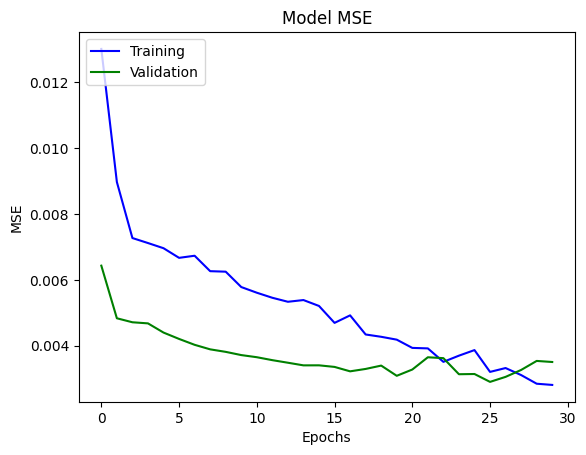

In [26]:
plt.plot(history_lr.history['loss'], color='b')
plt.plot(history_lr.history['val_loss'], color='g')

plt.title('Model MSE')
plt.ylabel('MSE')
plt.xlabel('Epochs')

plt.legend(['Training', 'Validation'], loc='upper left')

plt.show()

In [27]:
predictions_lr = model_lr.predict([X_test, X_test_img_lr])

2/2 [==============================] - 0s 32ms/step


In [28]:
# MSE
error = predictions_lr.flatten() - y_test
squared_error = error ** 2
MSE_lr = np.mean(squared_error)
print(MSE_lr)

0.003415564710044632


3. high resolution:

In [29]:
model_hr = merge_models(tabular_model, cnn_model_hr)
model_hr.compile(optimizer='adam', loss='mse', run_eagerly=True)

In [30]:
history_hr = model_hr.fit([X_train, X_train_img_hr], y_train, epochs = 30, batch_size = 32, 
                    #validation_data=([X_val, X_val_img], y_val), 
                    callbacks=[early_stopping], validation_split = (1/9))

Epoch 1/30
14/14 [==============================] - 84s 6s/step - loss: 0.0941 - val_loss: 0.0775
Epoch 2/30
14/14 [==============================] - 72s 5s/step - loss: 0.0578 - val_loss: 0.0467
Epoch 3/30
14/14 [==============================] - 73s 5s/step - loss: 0.0347 - val_loss: 0.0272
Epoch 4/30
14/14 [==============================] - 78s 6s/step - loss: 0.0210 - val_loss: 0.0155
Epoch 5/30
14/14 [==============================] - 74s 5s/step - loss: 0.0134 - val_loss: 0.0093
Epoch 6/30
14/14 [==============================] - 80s 6s/step - loss: 0.0094 - val_loss: 0.0067
Epoch 7/30
14/14 [==============================] - 86s 6s/step - loss: 0.0080 - val_loss: 0.0058
Epoch 8/30
14/14 [==============================] - 98s 7s/step - loss: 0.0074 - val_loss: 0.0055
Epoch 9/30
14/14 [==============================] - 79s 6s/step - loss: 0.0074 - val_loss: 0.0054
Epoch 10/30
14/14 [==============================] - 72s 5s/step - loss: 0.0070 - val_loss: 0.0053
Epoch 11/30
14/14 [

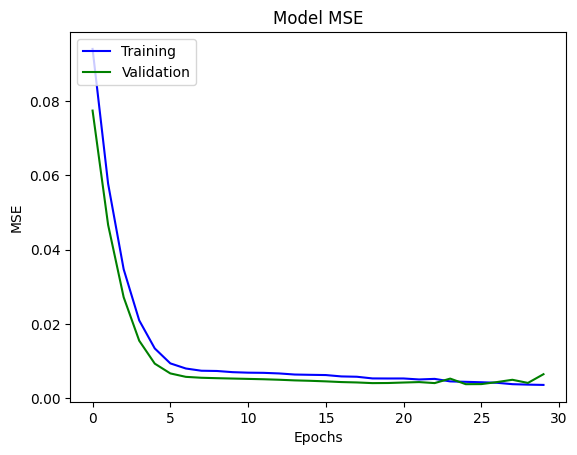

In [31]:
plt.plot(history_hr.history['loss'], color='b')
plt.plot(history_hr.history['val_loss'], color='g')

plt.title('Model MSE')
plt.ylabel('MSE')
plt.xlabel('Epochs')

plt.legend(['Training', 'Validation'], loc='upper left')

plt.show()

In [32]:
predictions_hr = model_hr.predict([X_test, X_test_img_hr])

2/2 [==============================] - 1s 527ms/step


In [33]:
error = predictions_hr.flatten() - y_test
squared_error = error ** 2
MSE_hr = np.mean(squared_error)
print(MSE_hr)

0.0062838061824016704


Model Comparison

In [34]:
index = ['Baseline', 'Low Resolution', 'High Resolution']
data = [MSE_baseline, MSE_lr, MSE_hr]

results = pd.DataFrame(data, index=index, columns=['MSE'])

In [35]:
results

MSE
Baseline         0.002949
Low Resolution   0.003416
High Resolution  0.006284

High resolution images + text data, seems better then text only, and text + low resolution.

Now we will fit just the high resolution images, without any text data. 

In [36]:
cnn_model = cnn((512, 512, 3))
cnn_model.compile(optimizer='adam', loss='mse')
history_cnn = cnn_model.fit(X_train_img_hr, y_train, epochs = 30, batch_size = 32, 
                    #validation_data=([X_val, X_val_img], y_val), 
                    callbacks=[early_stopping], validation_split = (1/9))


Epoch 1/30
14/14 [==============================] - 59s 4s/step - loss: 0.0295 - val_loss: 0.0313
Epoch 2/30
14/14 [==============================] - 47s 3s/step - loss: 0.0295 - val_loss: 0.0313
Epoch 3/30
14/14 [==============================] - 47s 3s/step - loss: 0.0295 - val_loss: 0.0315
Epoch 4/30
14/14 [==============================] - 47s 3s/step - loss: 0.0295 - val_loss: 0.0313
Epoch 5/30
14/14 [==============================] - 49s 4s/step - loss: 0.0295 - val_loss: 0.0312
Epoch 6/30
14/14 [==============================] - 48s 3s/step - loss: 0.0295 - val_loss: 0.0312
Epoch 7/30
14/14 [==============================] - 47s 3s/step - loss: 0.0295 - val_loss: 0.0312
Epoch 8/30
14/14 [==============================] - 47s 3s/step - loss: 0.0295 - val_loss: 0.0312
Epoch 9/30
14/14 [==============================] - 54s 4s/step - loss: 0.0295 - val_loss: 0.0312
Epoch 10/30
14/14 [==============================] - 53s 4s/step - loss: 0.0295 - val_loss: 0.0312
Epoch 11/30
14/14 [

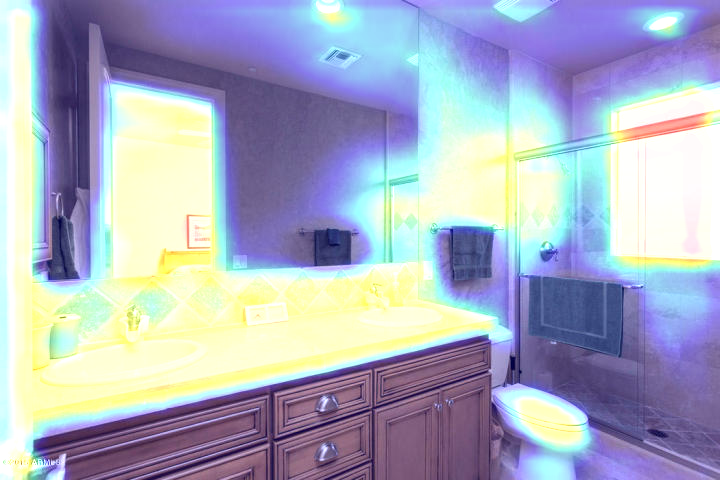

In [37]:
img_path = 'HousesDataset/22_bathroom.jpg' 
img = preprocess_image(img_path)  
heatmap = grad_cam(cnn_model, img, 'conv_layer3')

show_imgwithheat(img_path, heatmap)

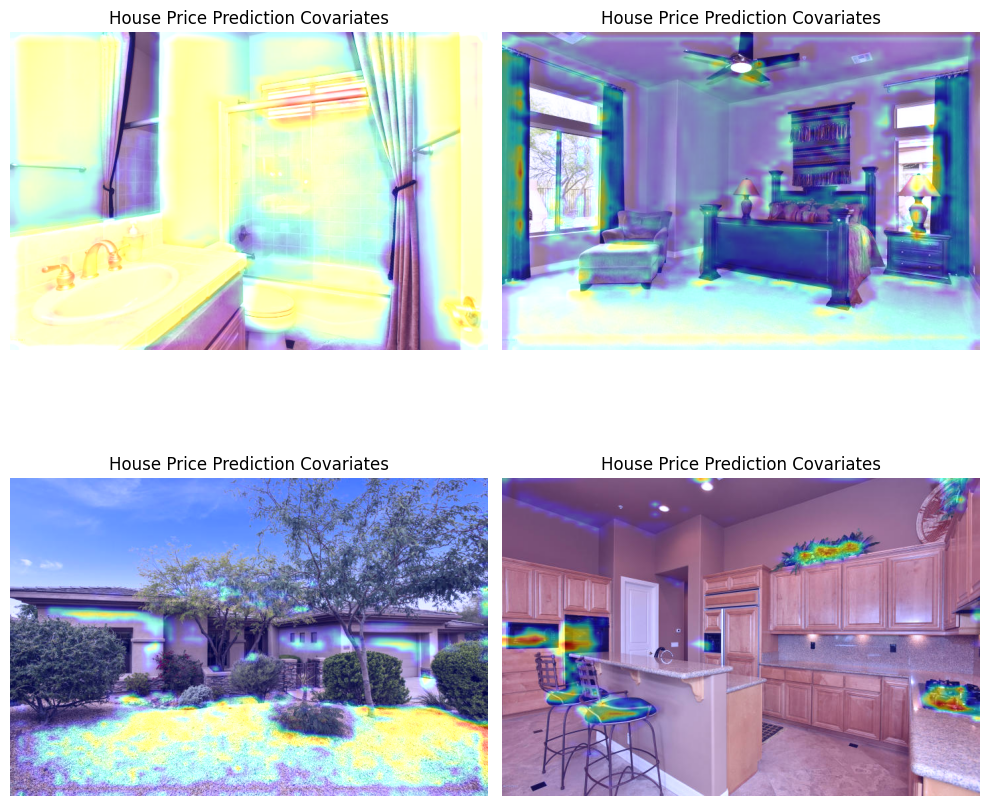

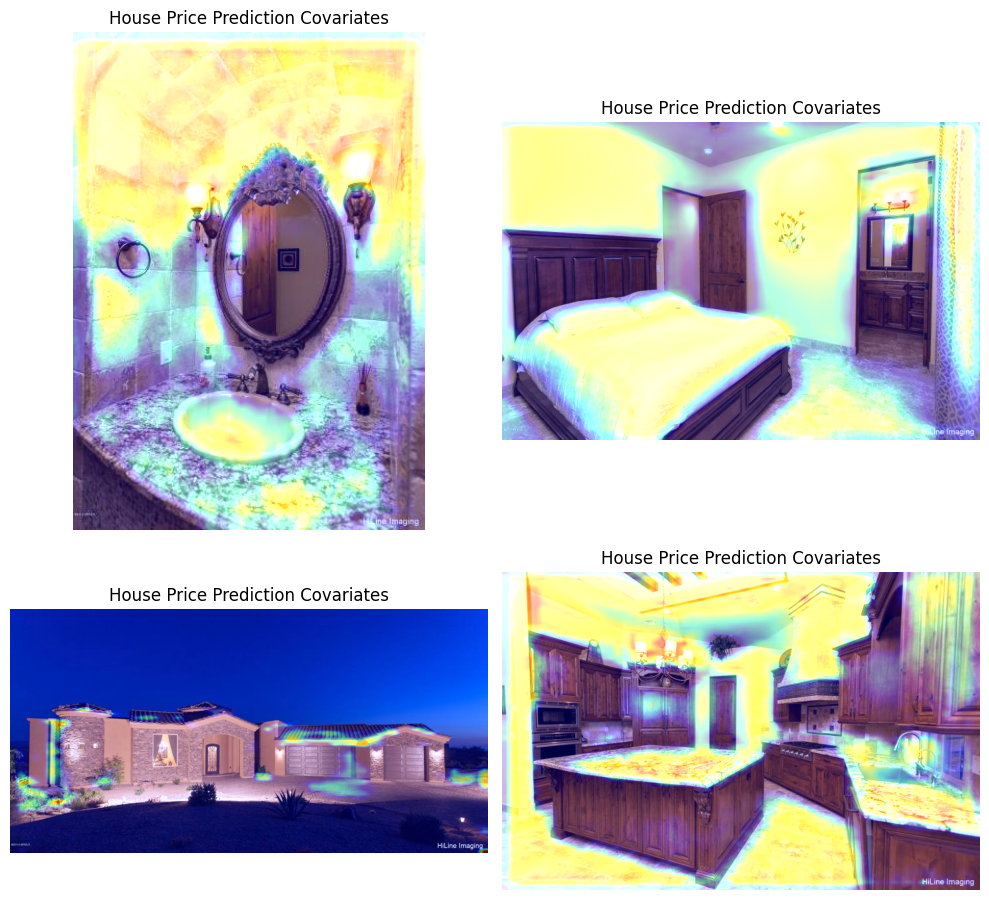

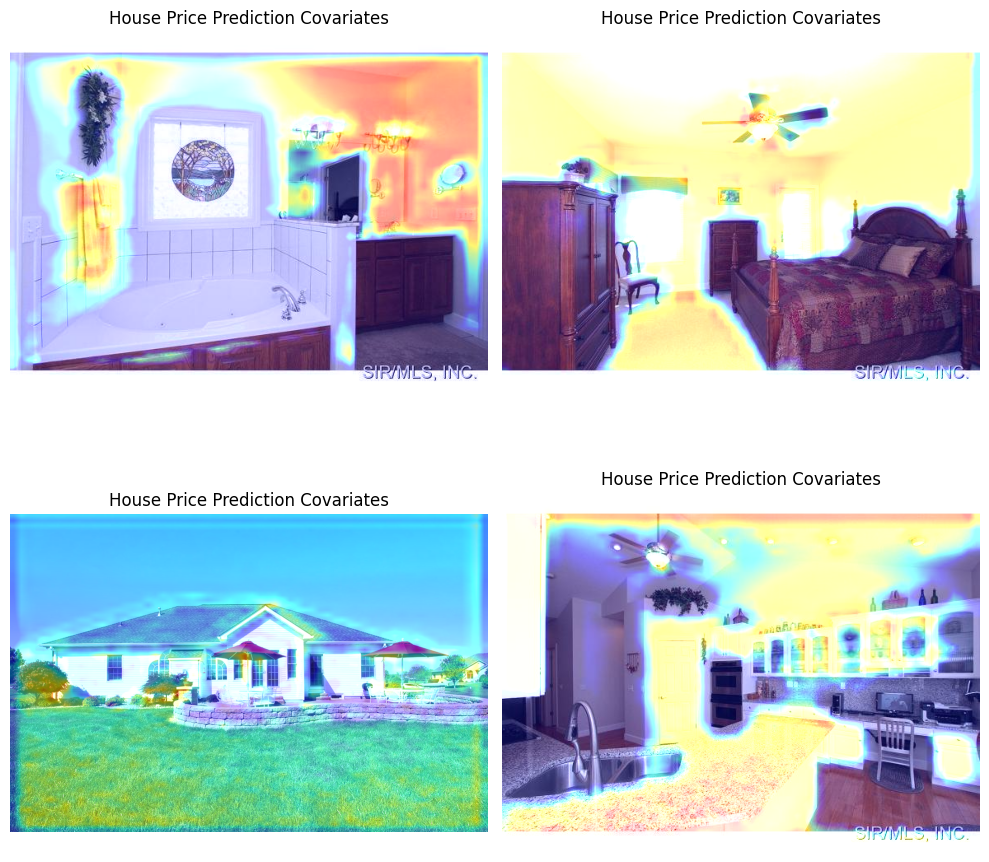

In [54]:
def plot_images_and_heatmaps(model, img_paths):
    # Loop through the list and generate the heatmaps
    for i in range(len(img_paths)//4):   # Each house has 4 images
        fig, axs = plt.subplots(2, 2, figsize=(10, 10))  # 2x2 grid of subplots
        for j in range(4):
            img_path = img_paths[i*4 + j]
            img = preprocess_image(img_path)
            heatmap = grad_cam(model, img, 'conv_layer3')
            imgwithheat = show_imgwithheat(img_path, heatmap, return_array=True)

            # Determine subplot position
            row = j // 2
            col = j % 2

            axs[row, col].imshow(imgwithheat)
            axs[row, col].set_title(f'House Price Prediction Covariates')
            axs[row, col].axis('off')

        plt.tight_layout()
        
img_paths = ['HousesDataset/20_bathroom.jpg', 'HousesDataset/20_bedroom.jpg', 'HousesDataset/20_frontal.jpg', 'HousesDataset/20_kitchen.jpg',
             'HousesDataset/2_bathroom.jpg', 'HousesDataset/2_bedroom.jpg', 'HousesDataset/2_frontal.jpg', 'HousesDataset/2_kitchen.jpg',
             'HousesDataset/70_bathroom.jpg', 'HousesDataset/70_bedroom.jpg', 'HousesDataset/70_frontal.jpg', 'HousesDataset/70_kitchen.jpg',]

plot_images_and_heatmaps(cnn_model, img_paths)


In [39]:
cnn_model2 = cnn((64, 64, 3))
cnn_model2.compile(optimizer='adam', loss='mse')
history_cnn2 = cnn_model2.fit(X_train_img_lr, y_train, epochs = 30, batch_size = 32, 
                    #validation_data=([X_val, X_val_img], y_val), 
                    callbacks=[early_stopping], validation_split = (1/9))

Epoch 1/30
14/14 [==============================] - 5s 97ms/step - loss: 0.0295 - val_loss: 0.0312
Epoch 2/30
14/14 [==============================] - 1s 82ms/step - loss: 0.0295 - val_loss: 0.0312
Epoch 3/30
14/14 [==============================] - 1s 79ms/step - loss: 0.0295 - val_loss: 0.0312
Epoch 4/30
14/14 [==============================] - 1s 77ms/step - loss: 0.0295 - val_loss: 0.0312
Epoch 5/30
14/14 [==============================] - 1s 72ms/step - loss: 0.0295 - val_loss: 0.0312
Epoch 6/30
14/14 [==============================] - 1s 76ms/step - loss: 0.0295 - val_loss: 0.0312
Epoch 7/30
14/14 [==============================] - 1s 90ms/step - loss: 0.0295 - val_loss: 0.0312
Epoch 8/30
14/14 [==============================] - 1s 81ms/step - loss: 0.0295 - val_loss: 0.0312
Epoch 9/30
14/14 [==============================] - 1s 82ms/step - loss: 0.0295 - val_loss: 0.0312
Epoch 10/30
14/14 [==============================] - 1s 64ms/step - loss: 0.0295 - val_loss: 0.0312
Epoch 11/

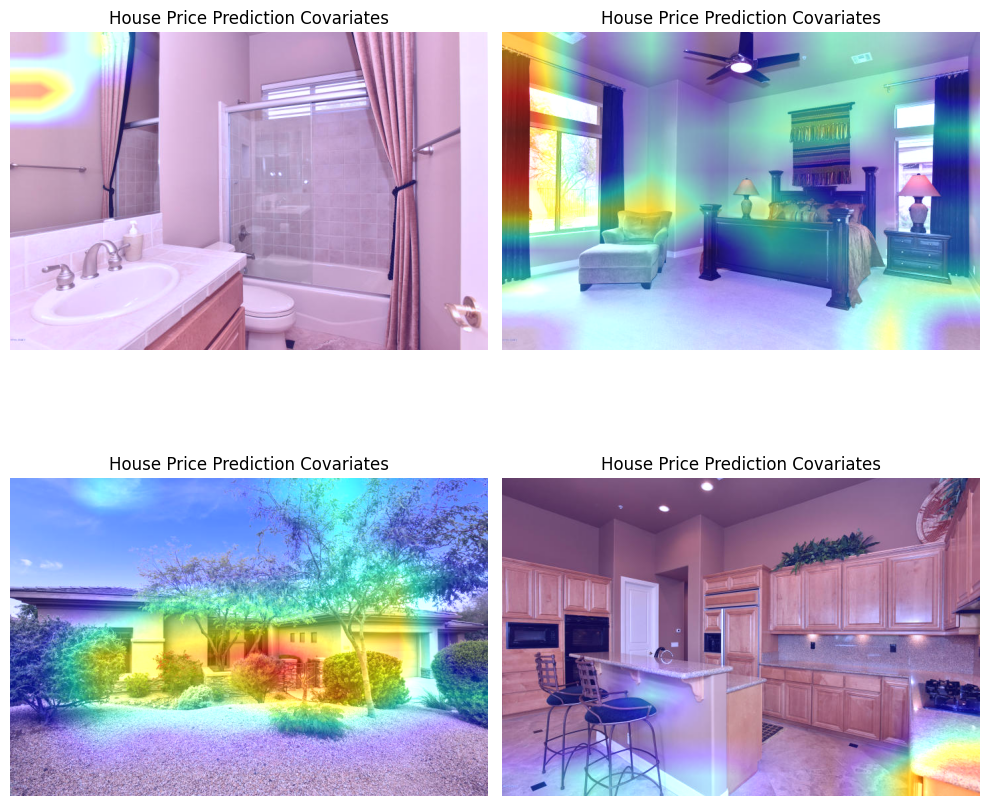

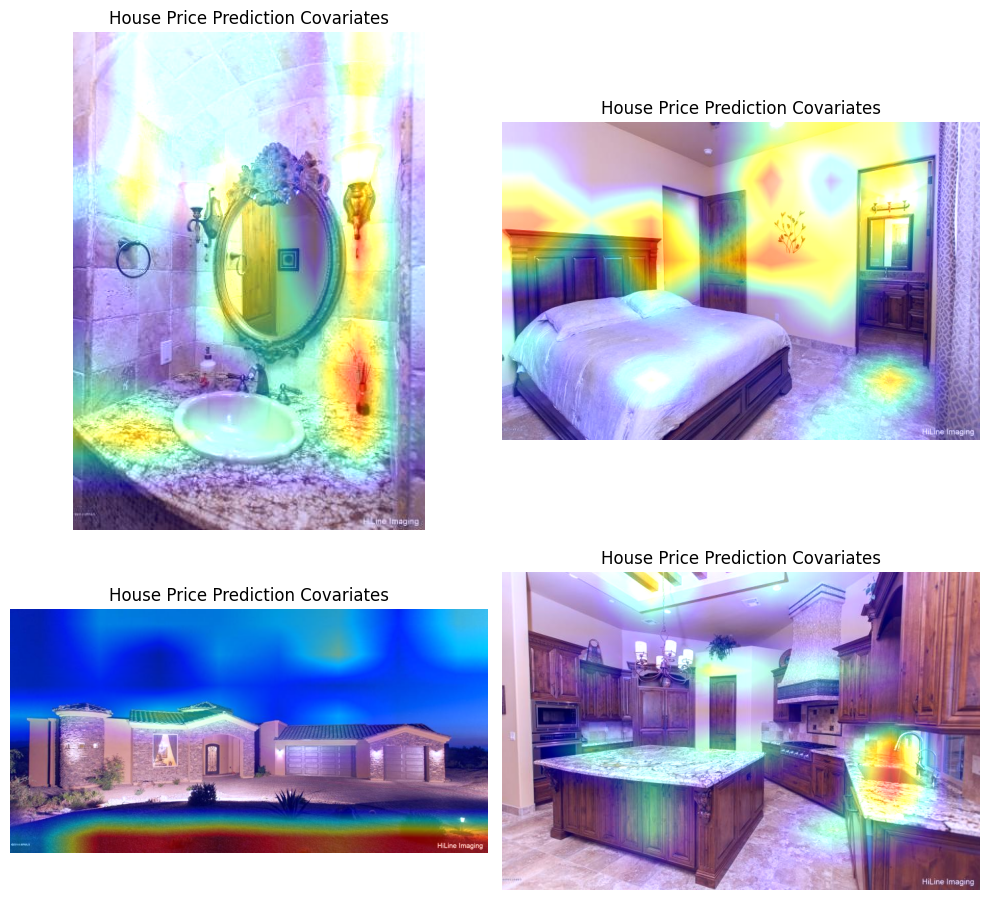

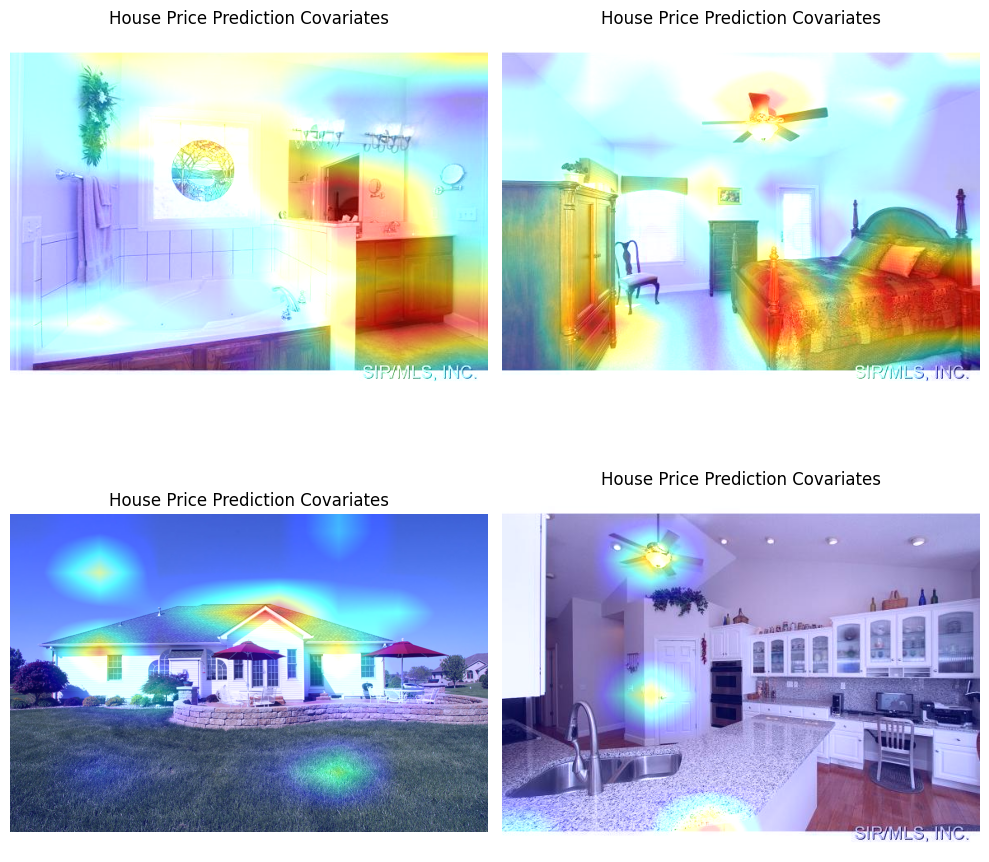

In [60]:
for i in range(len(img_paths)//4):   # Each house has 4 images
        fig, axs = plt.subplots(2, 2, figsize=(10, 10))  # 2x2 grid of subplots
        for j in range(4):
            img_path = img_paths[i*4 + j]
            img = preprocess_image(img_path, (64, 64)) #recale for cnn_model2
            heatmap = grad_cam(cnn_model2, img, 'conv_layer3')
            imgwithheat = show_imgwithheat(img_path, heatmap, return_array=True)

            # Determine subplot position
            row = j // 2
            col = j % 2

            axs[row, col].imshow(imgwithheat)
            axs[row, col].set_title(f'House Price Prediction Covariates')
            axs[row, col].axis('off')

        plt.tight_layout()
